In [1]:
# !pip install gymnasium[all]
# !apt update
# !apt-get install -y x11-apps

**Instructions**: Make sure you have the custom_env.py file and the img directory in the same directory as this notebook. Also, sometimes the environment does not render properly. Just re-run the required cells (or you can even restart the jupyter notebook and re-run everything again). It looks like the problem is only with rendering the environment using PyGame (and is probably a bug in Gymnasium or PyGame). The numeric values (like the values/policies) will still be computed accurately.

### Import stuff and implement functions

In [2]:
import gymnasium as gym
from tqdm import tqdm
import numpy as np
from custom_env import *
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


In [3]:
def policy(state, env):
    return np.array([0, 0.5, 0.5, 0])

In [4]:
def random_policy(state, env):
    return np.ones(env.action_space.n)/env.action_space.n

In [5]:
def evaluate_policy(policy, env, gamma):
    value = np.zeros(env.observation_space.n)
    new_value = np.zeros(env.observation_space.n)
    epsilon = 1e-10
    while True:
        for s in range(env.observation_space.n):
            actions = policy(s, env)
            new_value[s] = sum([ pi_a*sum([p*(r + gamma*value[s_]) for p, s_, r, term in env.P[s][a]]) for a, pi_a in enumerate(policy(s, env))])
        
        if np.linalg.norm(value - new_value) > epsilon:
            value = new_value.copy()
        else:
            break
    return value

def value_iteration(env, gamma):
    value = np.zeros(env.observation_space.n)
    new_value = np.zeros(env.observation_space.n)
    epsilon = 1e-10
    actions = range(env.action_space.n)
    ctr = 0
    while True:
        ctr += 1
        for s in range(env.observation_space.n):
            new_value[s] = max([sum([p*(r + gamma*value[s_]) for p, s_, r, term in env.P[s][a]]) for a in actions])
        
        if np.linalg.norm(value - new_value) > epsilon:
            value = new_value.copy()
        else:
            break
    return value, ctr

def greedy(value, env, gamma):
    q_value = np.zeros((env.observation_space.n, env.action_space.n))
    for s in range(env.observation_space.n):
        for a in range(env.action_space.n):
            q_value[s][a] = sum([p*(r + gamma*value[s_]) for p, s_, r, term in env.P[s][a]])
    def greedy_policy(state, env):
        policy = q_value[state] == max(q_value[state])
        return policy/np.sum(policy)

    return greedy_policy

def policy_iteration(env, gamma):
    policy = random_policy
    value = np.zeros(env.observation_space.n)
    epsilon = 1e-7
    ctr = 0
    while True:
        ctr += 1
        new_value = evaluate_policy(policy, env, gamma)
        
        if np.linalg.norm(value - new_value) > epsilon:
            value = new_value.copy()
            policy = greedy(value, env, gamma)
        else:
            break
        
    return value, ctr

In [6]:
def check_same_value(val1, val2):
    return np.linalg.norm(val1-val2) < 1e-15

In [7]:
def visualise_policy(policy, env, title='Optimal Policy'):
    fig, ax = plt.subplots()
    dir = [(-1, 0), (0, -1), (1, 0), (0, 1)]
    for s in range(env.observation_space.n):
        actions = policy(s, env)
        y, x= env.nrow - s//env.ncol, s%env.ncol
        ax.add_patch(Rectangle((x-0.5, y-0.5), 1, 1, fill=False, lw=1))
        for i, a in enumerate(actions):
            if a != 0:
                plt.arrow(x, y, 0.25*dir[i][0], 0.25*dir[i][1], head_width=0.1, head_length=0.1, color='black')
    # plt.grid()
    ax.set(xticklabels=[])
    ax.set(yticklabels=[])
    ax.axis('square')
    plt.title(title)
    plt.show()

### Frozen Lake Environment

In [8]:
gamma = 0.9
env = gym.make("FrozenLake-v1", render_mode='human', is_slippery=False)
observation, info = env.reset()

In [9]:
evaluate_policy(random_policy, env, gamma).reshape((4,4))

array([[0.00447726, 0.00422246, 0.01006676, 0.00411822],
       [0.00672196, 0.        , 0.02633371, 0.        ],
       [0.01867615, 0.05760701, 0.10697195, 0.        ],
       [0.        , 0.13038305, 0.39149016, 0.        ]])

In [10]:
pol_iter_opt_v, pol_iter_num = policy_iteration(env, gamma)
pol_iter_opt_v.reshape((4,4))

array([[0.59049, 0.6561 , 0.729  , 0.6561 ],
       [0.6561 , 0.     , 0.81   , 0.     ],
       [0.729  , 0.81   , 0.9    , 0.     ],
       [0.     , 0.9    , 1.     , 0.     ]])

In [11]:
val_iter_opt_v, val_iter_num = value_iteration(env, gamma)
val_iter_opt_v.reshape((4, 4))

array([[0.59049, 0.6561 , 0.729  , 0.6561 ],
       [0.6561 , 0.     , 0.81   , 0.     ],
       [0.729  , 0.81   , 0.9    , 0.     ],
       [0.     , 0.9    , 1.     , 0.     ]])

In [12]:
print('# of steps in Value Iteration:', val_iter_num)
print('# of steps in Policy Iteration:', pol_iter_num)

# of steps in Value Iteration: 7
# of steps in Policy Iteration: 3


In [13]:
check_same_value(val_iter_opt_v, pol_iter_opt_v)

True

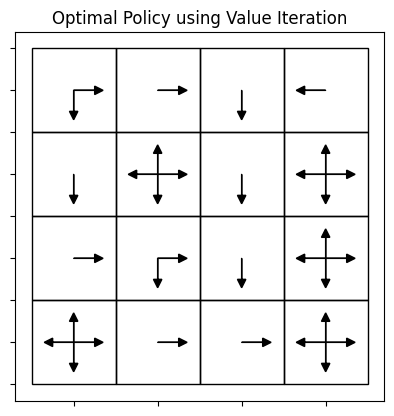

In [14]:
optimal_policy = greedy(value_iteration(env, gamma)[0], env, gamma)
visualise_policy(optimal_policy, env, 'Optimal Policy using Value Iteration')

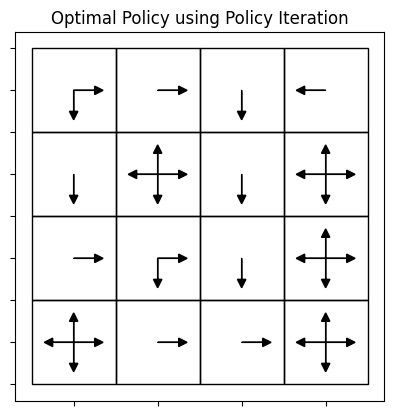

In [15]:
optimal_policy = greedy(policy_iteration(env, gamma)[0], env, gamma)
visualise_policy(optimal_policy, env, 'Optimal Policy using Policy Iteration')

In [16]:
for _ in tqdm(range(5)):
    state = 0
    while True:
        action = optimal_policy(state, env)  # agent policy that uses the observation and info
        indices = np.where(action == np.max(action))[0]
        random_action = np.random.choice(indices)
        observation, reward, terminated, truncated, info = env.step(random_action)
        state = observation
        if terminated or truncated:
            observation, info = env.reset()
            break

env.close()


100%|█████████████████████████████████████████████| 5/5 [00:08<00:00,  1.70s/it]


### Custom Environment

In [17]:
noise = 0
gamma = 0.9
env = CustomEnv(render_mode='human', noise=noise)
observation, info = env.reset()

In [18]:
evaluate_policy(random_policy, env, gamma).reshape((5,5))

array([[-0.55074521,  0.12036982,  0.84498255,  1.6009029 ,  2.52912057],
       [-1.46663589, -0.04559323,  1.18922273,  2.14011798,  4.58139184],
       [-3.03436475, -2.40231306,  0.        ,  2.09542201,  0.        ],
       [-5.95070015, -6.35138023, -4.81516508, -5.04935348, -1.46594133],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [19]:
pol_iter_opt_v, pol_iter_num = policy_iteration(env, gamma)
pol_iter_opt_v.reshape((5, 5))

array([[ 5.9049 ,  6.561  ,  7.29   ,  8.1    ,  9.     ],
       [ 5.31441,  7.29   ,  8.1    ,  9.     , 10.     ],
       [ 5.9049 ,  6.561  ,  0.     , 10.     ,  0.     ],
       [ 6.561  ,  7.29   ,  8.1    ,  9.     , 10.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ]])

In [20]:
val_iter_opt_v, val_iter_num = value_iteration(env, gamma)
val_iter_opt_v.reshape((5, 5))

array([[ 5.9049 ,  6.561  ,  7.29   ,  8.1    ,  9.     ],
       [ 5.31441,  7.29   ,  8.1    ,  9.     , 10.     ],
       [ 5.9049 ,  6.561  ,  0.     , 10.     ,  0.     ],
       [ 6.561  ,  7.29   ,  8.1    ,  9.     , 10.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ]])

In [21]:
print('# of steps in Value Iteration:', val_iter_num)
print('# of steps in Policy Iteration:', pol_iter_num)

# of steps in Value Iteration: 8
# of steps in Policy Iteration: 7


In [22]:
check_same_value(val_iter_opt_v, pol_iter_opt_v)

True

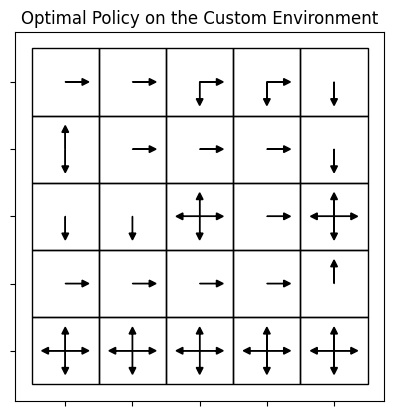

In [23]:
optimal_policy = greedy(value_iteration(env, gamma)[0], env, gamma)
visualise_policy(optimal_policy, env, 'Optimal Policy on the Custom Environment')

### Checking for different values of $\eta$ and $\gamma$

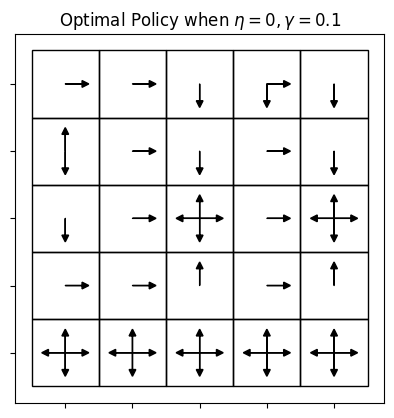

100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


In [24]:
noise = 0
gamma = 0.1
env = CustomEnv(render_mode='human', noise=noise)
observation, info = env.reset()

optimal_policy = greedy(value_iteration(env, gamma)[0], env, gamma)
visualise_policy(optimal_policy, env, 'Optimal Policy when $\eta = 0, \gamma = 0.1$')

for _ in tqdm(range(5)):
    state = 15
    while True:
        action = optimal_policy(state, env)  # agent policy that uses the observation and info
        indices = np.where(action == np.max(action))[0]
        random_action = np.random.choice(indices)
        observation, reward, terminated, truncated, info = env.step(random_action)
        state = observation
        if terminated or truncated:
            observation, info = env.reset()
            break

env.close()

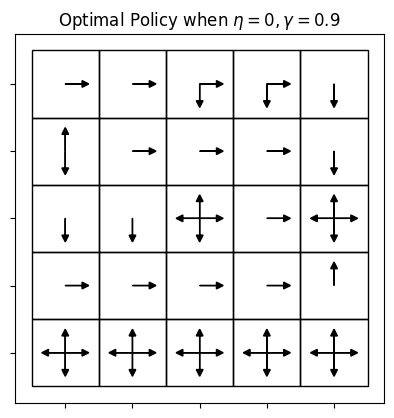

100%|█████████████████████████████████████████████| 5/5 [00:07<00:00,  1.48s/it]


In [25]:
noise = 0
gamma = 0.9
env = CustomEnv(render_mode='human', noise=noise)
observation, info = env.reset()

optimal_policy = greedy(value_iteration(env, gamma)[0], env, gamma)
visualise_policy(optimal_policy, env, 'Optimal Policy when $\eta = 0, \gamma = 0.9$')

for _ in tqdm(range(5)):
    state = 15
    while True:
        action = optimal_policy(state, env)  # agent policy that uses the observation and info
        indices = np.where(action == np.max(action))[0]
        random_action = np.random.choice(indices)
        observation, reward, terminated, truncated, info = env.step(random_action)
        state = observation
        if terminated or truncated:
            observation, info = env.reset()
            break

env.close()

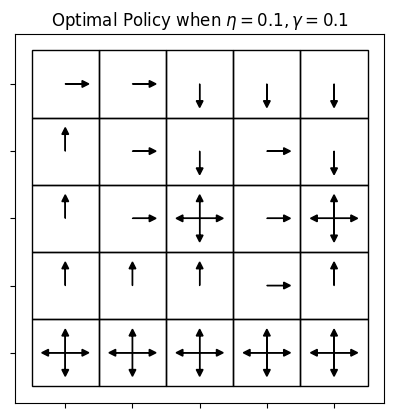

100%|█████████████████████████████████████████████| 5/5 [00:10<00:00,  2.07s/it]


In [26]:
noise = 0.1
gamma = 0.1
env = CustomEnv(render_mode='human', noise=noise)
observation, info = env.reset()

optimal_policy = greedy(value_iteration(env, gamma)[0], env, gamma)
visualise_policy(optimal_policy, env, 'Optimal Policy when $\eta = 0.1, \gamma = 0.1$')

for _ in tqdm(range(5)):
    state = 15
    while True:
        action = optimal_policy(state, env)  # agent policy that uses the observation and info
        indices = np.where(action == np.max(action))[0]
        random_action = np.random.choice(indices)
        observation, reward, terminated, truncated, info = env.step(random_action)
        state = observation
        if terminated or truncated:
            observation, info = env.reset()
            break

env.close()

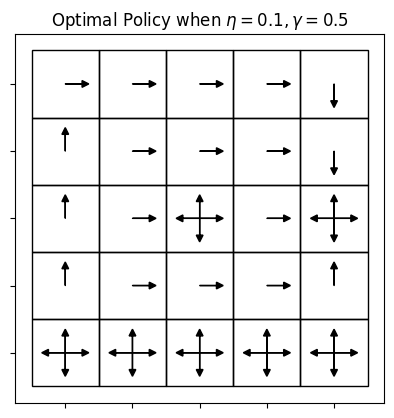

100%|█████████████████████████████████████████████| 5/5 [00:14<00:00,  2.88s/it]


In [27]:
noise = 0.1
gamma = 0.5
env = CustomEnv(render_mode='human', noise=noise)
observation, info = env.reset()

optimal_policy = greedy(value_iteration(env, gamma)[0], env, gamma)
visualise_policy(optimal_policy, env, 'Optimal Policy when $\eta = 0.1, \gamma = 0.5$')

for _ in tqdm(range(5)):
    state = 15
    while True:
        action = optimal_policy(state, env)  # agent policy that uses the observation and info
        indices = np.where(action == np.max(action))[0]
        random_action = np.random.choice(indices)
        observation, reward, terminated, truncated, info = env.step(random_action)
        state = observation
        if terminated or truncated:
            observation, info = env.reset()
            break

env.close()